#### 09  Results & Limitations

**Goal.** Close the project with an honest, replicable evaluation of the strategy and its limits.

**What we compare.** We benchmark the **GATED strategy** against **XBI** (the equal-weight biotech ETF, broadly used as a small/mid-cap biotech proxy) over the **same 3-month window** used in the GATED backtest. We align calendars (common trading days), normalize both series to 100 at the common start, and compute comparable metrics.

---

### What this notebook does

1) **GATED vs XBI (same dates)**
   - Load the GATED equity curve from the backtest.
   - Fetch XBI (adjusted close).
   - **Align calendars** (common trading days) for an apples-to-apples comparison.
   - Report **Total Return, Max Drawdown, Sharpe** (both daily and annualized) on the aligned window.
   - Plot **normalized equity curves** (index 100 at start) for a visual read.

2) **“Beating beta” check (risk-adjusted, HAC-robust)**  
Regress daily strategy returns on XBI returns:
$$
r_{s,t}=\alpha+\beta\,r_{b,t}+\varepsilon_t,
\qquad
\beta=\frac{\operatorname{Cov}(r_b,r_s)}{\operatorname{Var}(r_b)},
\qquad
\alpha=\mathbb{E}[r_s]-\beta\,\mathbb{E}[r_b].
$$

HAC/Newey–West inference for $$\alpha$$ 

(OLS with robust SE):

$$
t_{\text{HAC}}(\hat{\alpha})=\frac{\hat{\alpha}}{\operatorname{se}_{\text{HAC}}(\hat{\alpha})},
\qquad
L=\left\lfloor 1.1447\,n^{1/3}\right\rfloor.
$$

Information Ratio:

$$
\text{IR}_{\text{daily}}=\frac{\alpha_d}{\sigma(\varepsilon_t)},
\qquad
\text{IR}_{\text{ann}}=\text{IR}_{\text{daily}}\sqrt{252}.
$$


$$
\hat{\alpha},\ \hat{\beta},\ \mathrm{IR},\ t_{\mathrm{HAC}}
$$
cautiously when \(n\) is small. 

---
3) **Results summary**
   - Summarize where **GATED** improves vs always-on baselines and vs **XBI** on this window, with emphasis on **aligned metrics** and **HAC-robust alpha** evidence.


 PERFORMANCE(net of costs 100bps): 
       TotRet    MaxDD Sharpe_ann Sharpe_daily
XBI     0.20%  -18.39%       0.20        0.013
GATED  10.83%   -9.25%       1.48        0.093


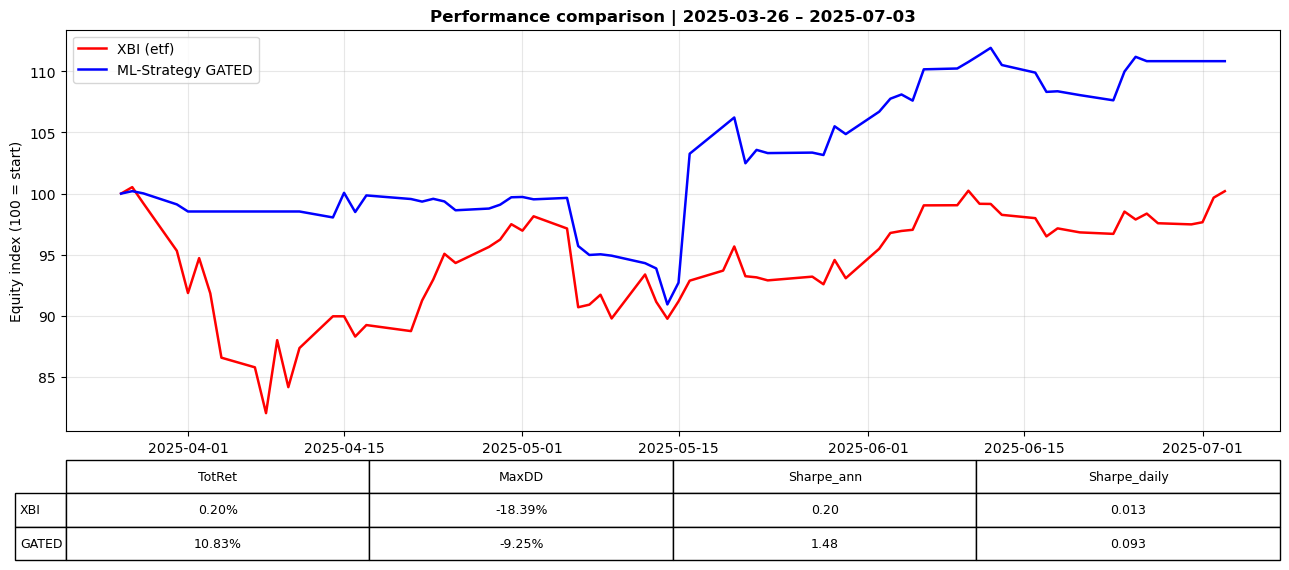

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader.stooq import StooqDailyReader

EQUITY_FILE = "bt_runs/portfolio_equity_GATED.csv"
BENCH_TKR   = "XBI"


def _as_series(x: pd.Series | pd.DataFrame) -> pd.Series:
    
    if isinstance(x, pd.DataFrame):
        x = x.squeeze("columns")
    return x.astype(float)

def fetch_bench(tkr: str, start: pd.Timestamp, end: pd.Timestamp, auto_adjust: bool = True) -> pd.Series:
   
    s = pd.Series(dtype=float)
    try:
        
        df = yf.download(tkr, start=start, end=end + pd.Timedelta(days=1),
                         auto_adjust=auto_adjust, progress=False)
        if not df.empty:
        
            s = df["Close"].astype(float)
    except Exception:
        pass
    if s.empty:
        tkr_stooq = tkr if tkr.endswith(".US") else (tkr + ".US")
        s = StooqDailyReader(tkr_stooq, start, end).read()["Close"].astype(float)
        s.name = tkr
    return s.sort_index()

def normalize(s: pd.Series) -> pd.Series:
    s = _as_series(s)
    base = s.iloc[0]
    return s * 100.0 / base

def sharpe(curve, annualize=True, freq=252):
    s = _as_series(curve)              
    r = s.pct_change().dropna()
    if r.empty:
        return 0.0
    sd = r.std(ddof=1)
    if not np.isfinite(sd) or sd == 0:
        return 0.0
    val = r.mean() / sd
    return float(val * np.sqrt(freq)) if annualize else float(val)

def tot_return(eq: pd.Series) -> float:
    s = _as_series(eq)
    if len(s) < 2:
        return float("nan")
    
    a = s.to_numpy()
    return float(a[-1] / a[0] - 1.0)

def max_dd(eq: pd.Series) -> float:
    s = _as_series(eq)
    if s.empty:
        return float("nan")
    dd = s / s.cummax() - 1.0
    return float(dd.min())

eq_df = pd.read_csv(EQUITY_FILE, parse_dates=["date"]).set_index("date").sort_index()
eq = _as_series(eq_df["equity"])


start, end = eq.index.min(), eq.index.max()
bench = fetch_bench(BENCH_TKR, start, end, auto_adjust=True)

common_idx = eq.index.intersection(bench.index)
eq_aligned    = _as_series(eq.loc[common_idx])
bench_aligned = _as_series(bench.loc[common_idx])

met_df_float = pd.DataFrame({
    "TotRet":       [tot_return(bench_aligned),    tot_return(eq_aligned)],
    "MaxDD":        [max_dd(bench_aligned),       max_dd(eq_aligned)],
    "Sharpe_ann":   [sharpe(bench_aligned, True), sharpe(eq_aligned, True)],
    "Sharpe_daily": [sharpe(bench_aligned, False),sharpe(eq_aligned, False)],
}, index=[BENCH_TKR, "GATED"])

met_fmt = met_df_float.copy()
met_fmt["TotRet"]       = met_fmt["TotRet"].map(lambda x: f"{x:.2%}")
met_fmt["MaxDD"]        = met_fmt["MaxDD"].map(lambda x: f"{x:.2%}")
met_fmt["Sharpe_ann"]   = met_fmt["Sharpe_ann"].map(lambda x: f"{x:.2f}")
met_fmt["Sharpe_daily"] = met_fmt["Sharpe_daily"].map(lambda x: f"{x:.3f}")

print("\n PERFORMANCE(net of costs 100bps): ")
print(met_fmt)

fig, ax = plt.subplots(figsize=(13,6))
ax.plot(normalize(bench_aligned), label=f"{BENCH_TKR} (etf)", lw=1.8, color = 'red')
ax.plot(normalize(eq_aligned),    label="ML-Strategy GATED", lw=1.8, color = 'blue')
ax.set_title(f"Performance comparison | {eq_aligned.index[0].date()} – {eq_aligned.index[-1].date()}",
             fontweight="bold")
ax.set_ylabel("Equity index (100 = start)")
ax.grid(alpha=.3)
ax.legend(loc="upper left")

table = ax.table(
    cellText=met_fmt.values,
    rowLabels=met_fmt.index,
    colLabels=met_fmt.columns,
    cellLoc="center", loc="lower center",
    bbox=[0, -0.32, 1, 0.25]
)
table.auto_set_font_size(False); table.set_fontsize(9)
plt.tight_layout(); plt.show()

## Results (GATED vs XBI, same 3-month window)

**Bottom line.** On the aligned window the **GATED** strategy outperforms **XBI**:
- **TotRet:** 10.83% vs 0.20%
- **MaxDD:** −9.25% vs −18.39% (shallower drawdown)
- **Sharpe(annualized):** **1.48** vs 0.20

The chart uses **normalized equities (100 = start)** and **common trading days only** so the comparison is apples-to-apples.

---

### Why the Sharpe here is higher than in the previous notebook

1) **Same-dates alignment & different window.**  
   Here we compute returns **only on the 3-month intersection of trading days** (`common_idx`). The earlier notebook used a slightly different span/index, so the mix of wins/losses was different.

2) **Same math, different calendar handling.**  
   This notebook’s helper computes Sharpe on **trading days only** (`pct_change().dropna()` on the aligned series).  
   The earlier helper (`calculate_metrics`) worked on a **calendar index** from the backtester (with weekends/holidays forward-filled), which changes the volatility estimate and can shift Sharpe.

3) **Short sample sensitivity.**  
   With ~**68** daily observations, **small indexing or window differences move Sharpe**.

---

### Costs (assumptions & stress tests)

The chart below is **net of costs = 100 bps round-trip**, i.e., **10 bps commission per side** + **40 bps slippage per side** (entry & exit).

In the previous notebook(08) we stress-tested execution by varying **slippage per side** (commission fixed at **10 bps/side**). Results remain above the benchmark (**XBI**) across realistic ranges.

## Scenarios (slippage per side)(small-cap bio-tech | market cap  100M-2B)

| Scenario                      | Slippage / side | Total Return | MaxDD   | Round-trip cost* |
|------------------------------|----------------:|-------------:|--------:|-----------------:|
| Base – positive |          0.004  |       10.8%  |  −9.2%  | **1.00%** (100 bps) |
| Base – conservative (a)         |          0.005  |        9.0%  | −10.0%  | **1.20%** (120 bps) |
| Base – conservative  (b)        |          0.006  |        7.2%  | −10.6%  | **1.40%** (140 bps) |
| Stress                       |          0.007  |        5.4%  | −11.3%  | **1.60%** (160 bps) |
| Stress – high                |          0.009  |        1.9%  | −12.7%  | **2.00%** (200 bps) |
| Stress – very high           |          0.010  |       0.26%  | −13.3%  | **2.20%** (220 bps) |

\* **Round-trip cost formula:**  
`RTC = 2 × (commission per side + slippage per side)`  
with commission per side fixed at `0.001` (10 bps).

---
**Notes**
- All numbers are **net of costs** under each assumption.  
- “**Per side**” means the slippage percentage applies to both entry and exit.  
- Total **round-trip cost = 2 × (commission per side + slippage per side)**.

**Costs model: constant % slippage by side + commission — a simplification suitable for sensitivity analysis; real costs depend on spread, depth, volatility, and participation.**

---


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from math import floor
print(len(eq_aligned), len(bench_aligned))
print("Symmetric diff:", eq_aligned.index.symmetric_difference(bench_aligned.index).shape)
rs = _as_series(eq_aligned).pct_change().dropna().rename("rs")
rb = _as_series(bench_aligned).pct_change().dropna().rename("rb")
df = pd.concat([rb, rs], axis=1).dropna()
C = df.cov(ddof=1)
beta    = C.loc["rb", "rs"] / C.loc["rb", "rb"]
alpha_d = df["rs"].mean() - beta * df["rb"].mean()  
resid   = df["rs"] - (alpha_d + beta * df["rb"])    
n       = len(df)
X = sm.add_constant(df["rb"])  
y = df["rs"]
L = int(floor(1.1447 * n ** (1/3)))  
res_hac      = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": L})
alpha_hat    = res_hac.params["const"]        
t_alpha_hac  = res_hac.tvalues["const"]
p_alpha_hac  = res_hac.pvalues["const"]
se_alpha_hac = res_hac.bse["const"]
ir_daily = alpha_d / resid.std(ddof=1)


print(f"n={n}  beta={beta:.2f}  alpha_d={alpha_d:.2%}")
print(f"HAC: L={L}  alpha_hat={alpha_hat:.6f}  t_alpha={t_alpha_hac:.2f}  p={p_alpha_hac:.3f}  se={se_alpha_hac:.6f}")
print(f"IR_daily = {ir_daily:.4f}")

69 69
Symmetric diff: (0,)
n=68  beta=0.28  alpha_d=0.16%
HAC: L=4  alpha_hat=0.001584  t_alpha=0.85  p=0.394  se=0.001857
IR_daily = 0.0948


# GATED vs XBI – Alpha Check 

## Calendar alignment
- `len(eq_aligned) = len(bench_aligned) = 69`  
- Symmetric diff = `0` → same dates (coherent comparison)  
- `pct_change().dropna()` ⇒ `n = 68` observations (first is `NaN` and removed)

## Return dataset
- `rs` = **GATED** daily returns  
- `rb` = **XBI** daily returns  
- `df = [rb, rs]` perfectly aligned

## Beta & alpha estimation (daily)
Formulas:
β = cov(rb, rs) / var(rb)

α_d = mean(rs) − β · mean(rb)


Estimated values:

| Metric       | Value           | Comment                          |
|--------------|----------------:|----------------------------------|
| β            | **0.28**        | Low exposure to sector beta      |
| α (daily)    | **0.16%**       | (≈ 0.001642) Average daily alpha |

## Active returns, IR, and HAC significance
Residuals (active returns):
ε = rs − (α + β · rb)

| Metric              | Value       | Notes                                   |
|---------------------|------------:|-----------------------------------------|
| IR_daily            | **0.0948**  | `α_d / σ(ε)`                            |
| Annualized IR (≈)   | **~1.50**   | `0.0948 · √252`        |
| Newey–West (L = 4) t_α | **0.85** |                                         |
| p-value             | **0.394**   |                                         |
| se(α_d)             | **0.001857**|                                         |
| 95% CI for α_d      | **[−0.21%, +0.53%]** | includes 0                  |

## Interpretation
- **Positive but not significant alpha**: p ≈ 0.39 with a **short sample** (n = 68).  
- **Low correlation with XBI**: β ≈ 0.28 ⇒ performance largely **idiosyncratic/regime-driven**.  
- **Day-level efficiency looks fine**: IR_daily 0.0948 maps to annualized IR ~1.50, but **statistical significance remains limited** in this short window.

**Bottom line:** encouraging signs (α > 0, low β), but **preliminary evidence**; more observations are needed to assess statistical robustness.


_________________________________________________________________________________________________________________________________

## Limitations (and why they matter)

**In short:** the *stacked ML (XGB+RF) + meta-gating macro* does seem to “see something,” and in favorable regimes the **GATED** variant outperforms XBI on a risk/return basis. The evidence is **encouraging but still preliminary**: we need more data and stricter validation to make a confident claim.

---

### Data & coverage
- **Window limits (2024-01 → 2025-07-01)** due to **free-API constraints**: may not span full regime cycles; results can be sensitive to idiosyncratic periods.
- **Options data**: ~**40% imputed** with the median → reduces information variance and can bias signals. (Future: peer-group or model-based imputation, explicit “is_missing” flags.)
- **NLP still basic**: text features are intentionally simple; more domain-tuned NLP could add signal.

---

### Execution realism
- **Static slippage/costs** (bps) and no **liquidity filters** (price/ADV) or **exposure caps** (gross/net, per-name/sector).
- **Daily bars**: stop/target/trailing approximated at the close (no bar-cross order logic); no handling of **halts/limit-up/down** or **borrow fees** for shorts.
- **Calendar**: some reports rely on a civil-day index; a **business-day** calendar everywhere keeps volatility/Sharpe consistent.

---

### Feature engineering & consistency
- **T+1 alignment**: already enforced, but worth re-checking whenever new features/events are added (no look-ahead).

---

## Validation plan (next steps)
1. **Paper trading** for 3–6 months: immutable log of signals/fills; compare **realized vs backtest** (slippage, turnover, capacity, borrow).
2. **Risk caps** (gross/net, per-name/sector) and **standardized ATR**.
3. **Ablations**: macro-gate ON/OFF, options ON/OFF, NLP ON/OFF to quantify each component’s contribution.

---

## Exploratory extensions
- **Sector transfer**: test in **energy** / **commodities** with sector-specific macro features.
- **Large-cap event-driven (10-Q/earnings)**: include fundamental features (e.g., **DSO momentum**, accruals, guidance surprise) in the ML model.
- **Richer NLP**: domain-tuned models, event windows, relevance scoring.

---

### Conclusion
The **regime-aware** approach looks **promising**: the ensemble ML plus macro/technical/NLP/options features appear to capture useful signals and, in the right regimes, **outperform XBI**. The fair takeaway today is **encouraging potential**, **not yet a proven edge**. The plan is to **validate live** and **broaden the horizon** to build a more robust and generalizable assessment.